## 量子回路学習

まず、必要なライブラリを最初にインポートします。

In [ ]:
import sys
import shutil
import tarfile
from google.colab import drive

drive.mount('/content/gdrive')
shutil.copy('/content/gdrive/MyDrive/qcintro.tar.gz', '.')
with tarfile.open('qcintro.tar.gz', 'r:gz') as tar:
    tar.extractall(path='/root/.local')

sys.path.append('/root/.local/lib/python3.10/site-packages')

!git clone -b branch-2024 https://github.com/UTokyo-ICEPP/qc-workbook-lecturenotes
!cp -r qc-workbook-lecturenotes/qc_workbook /root/.local/lib/python3.10/site-packages/

In [1]:
# Tested with python 3.10.11, qiskit 0.42.1, numpy 1.23.5, scipy 1.9.3
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output
from sklearn.preprocessing import MinMaxScaler

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter, ParameterVector
from qiskit.circuit.library import TwoLocal, ZFeatureMap, ZZFeatureMap
from qiskit.primitives import Estimator, Sampler, BackendEstimator
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.algorithms.classifiers import VQC
#from qiskit.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit_algorithms.optimizers import SPSA, COBYLA
from qiskit_ibm_runtime import Session, Sampler as RuntimeSampler
from qiskit_ibm_runtime.accounts import AccountNotFoundError
from qiskit_aer import AerSimulator

## 初歩的な例
ある入力$\{x_i\}$と、既知の関数$f$による出力$y_i=f(x_i)$が学習データとして与えられた時に、そのデータから関数$f$を近似的に求める問題を考えてみます。例として、$f(x)=x^3$としてみます。

### 学習データの準備

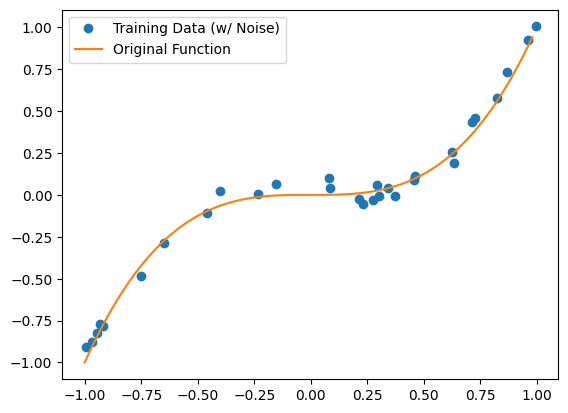

In [2]:
random_seed = 0
rng = np.random.default_rng(random_seed)

# Qubit数、変分フォームのレイヤー数、訓練サンプル数の定義など
nqubit = 3
nlayer = 5
x_min = -1.
x_max = 1.
num_x_train = 30
num_x_validation = 20

# 関数の定義
func_to_learn = lambda x: x ** 3

# 学習用データセットの生成
x_train = rng.uniform(x_min, x_max, size=num_x_train)
y_train = func_to_learn(x_train)

# 関数に正規分布ノイズを付加
mag_noise = 0.05
y_train_noise = y_train + rng.normal(0., mag_noise, size=num_x_train)

# 検証用データセットの生成
x_validation = rng.uniform(x_min, x_max, size=num_x_validation)
y_validation = func_to_learn(x_validation) + rng.normal(0., mag_noise, size=num_x_validation)

# 学習用データをプロットして確認
x_list = np.arange(x_min, x_max, 0.02)
plt.plot(x_train, y_train_noise, "o", label='Training Data (w/ Noise)')
plt.plot(x_list, func_to_learn(x_list), label='Original Function')
plt.legend()

### 量子状態の生成

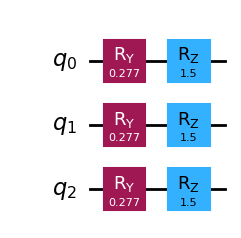

In [3]:
u_in = QuantumCircuit(nqubit, name='U_in')
x = Parameter('x')

for iq in range(nqubit):
    # parameter.arcsin()はparameterに値vが代入された時にarcsin(v)になるパラメータ表現
    u_in.ry(x.arcsin(), iq)
    # arccosも同様
    u_in.rz((x * x).arccos(), iq)

u_in.assign_parameters({x: x_train[0]}).draw('mpl')

### 変分フォームを使った状態変換

54 parameters


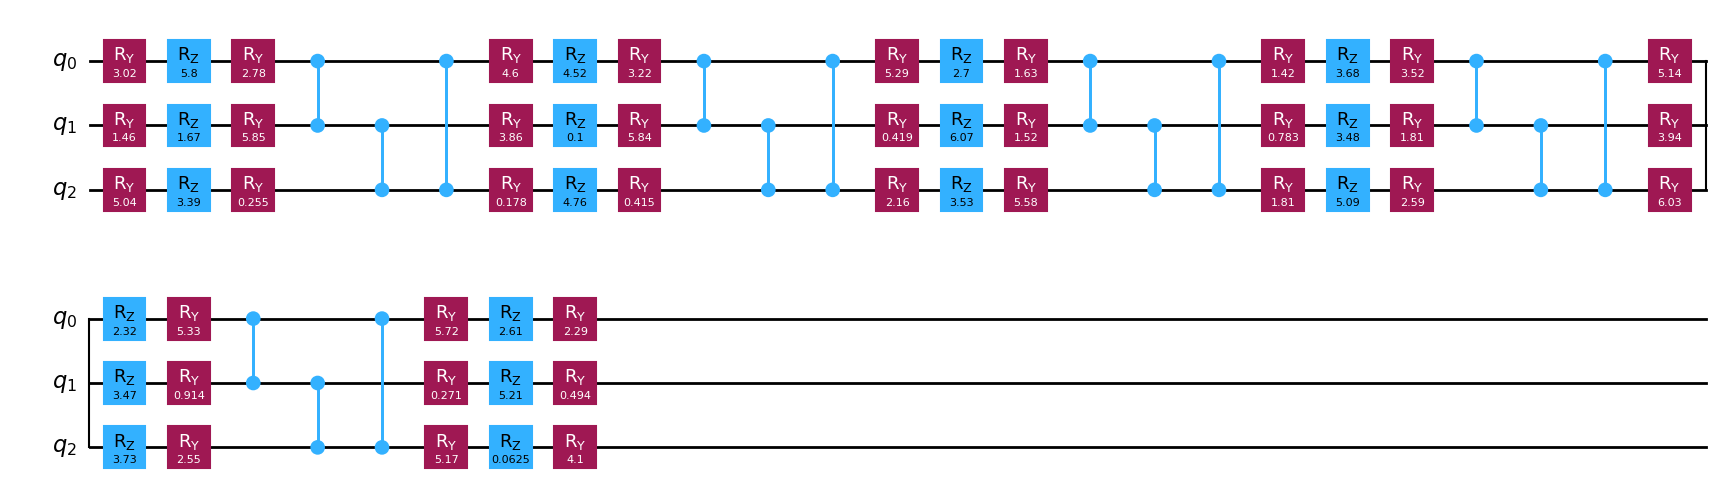

In [4]:
u_out = QuantumCircuit(nqubit, name='U_out')

# 長さ0のパラメータ配列
theta = ParameterVector('θ', 0)

# thetaに一つ要素を追加して最後のパラメータを返す関数
def new_theta():
    theta.resize(len(theta) + 1)
    return theta[-1]

for iq in range(nqubit):
    u_out.ry(new_theta(), iq)

for iq in range(nqubit):
    u_out.rz(new_theta(), iq)

for iq in range(nqubit):
    u_out.ry(new_theta(), iq)

for il in range(nlayer):
    for iq in range(nqubit):
        u_out.cz(iq, (iq + 1) % nqubit)

    for iq in range(nqubit):
        u_out.ry(new_theta(), iq)

    for iq in range(nqubit):
        u_out.rz(new_theta(), iq)

    for iq in range(nqubit):
        u_out.ry(new_theta(), iq)

print(f'{len(theta)} parameters')

theta_vals = rng.uniform(0., 2. * np.pi, size=len(theta))

u_out.assign_parameters(dict(zip(theta, theta_vals))).draw('mpl')

### 測定とモデル出力

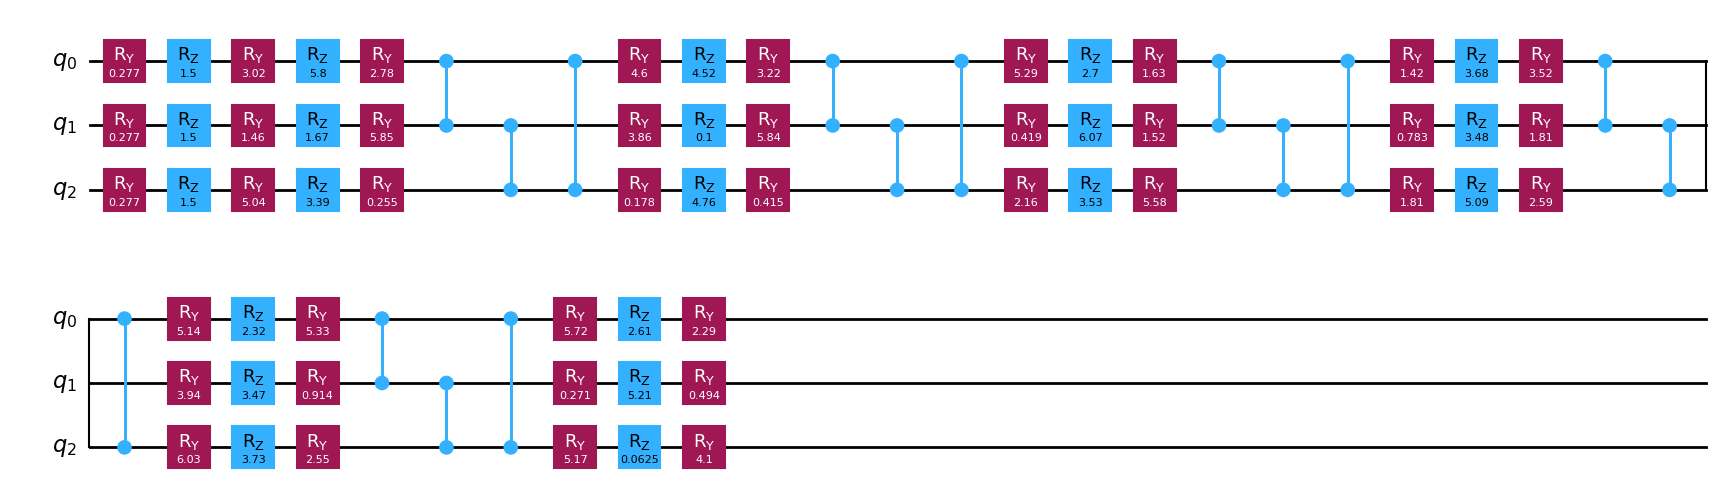

In [5]:
model = QuantumCircuit(nqubit, name='model')

model.compose(u_in, inplace=True)
model.compose(u_out, inplace=True)

assign_params = dict(zip(theta, theta_vals))
assign_params[x] = x_train[0]

model.assign_parameters(assign_params).draw('mpl')

In [8]:
# 今回はバックエンドを利用しない（量子回路シミュレーションを簡略化した）Estimatorクラスを使う
#estimator = Estimator()
backend = AerSimulator()
estimator = BackendEstimator(backend)

# 与えられたパラメータの値とxの値に対してyの値を計算する
def yvals(param_vals, x_vals=x_train):
    circuits = list()
    for x_val in x_vals:
        # xだけ数値が代入された変分回路
        circuits.append(model.assign_parameters({x: x_val}))

    # 観測量はIIZ（右端が第0量子ビット）
    observable = SparsePauliOp('I' * (nqubit - 1) + 'Z')

    # shotsは関数の外で定義
    job = estimator.run(circuits, [observable] * len(circuits), [param_vals] * len(circuits), shots=shots)

    return np.array(job.result().values)

def objective_function(param_vals):
    return np.sum(np.square(y_train_noise - yvals(param_vals)))

def callback_function(param_vals):
    # lossesは関数の外で定義
    losses.append(objective_function(param_vals))

    if len(losses) % 10 == 0:
        print(f'COBYLA iteration {len(losses)}: cost={losses[-1]}')

In [9]:
# COBYLAの最大ステップ数
maxiter = 100
# COBYLAの収束条件（小さいほどよい近似を目指す）
tol = 0.01
# バックエンドでのショット数
shots = 1000

optimizer = COBYLA(maxiter=maxiter, tol=tol, callback=callback_function)

COBYLA iteration 10: cost=1.7743665317094708
COBYLA iteration 20: cost=2.206232317978475
COBYLA iteration 30: cost=2.9447050709033245
COBYLA iteration 40: cost=0.9811384491321211
COBYLA iteration 50: cost=0.2893332793117246
COBYLA iteration 60: cost=0.6907783406876402
COBYLA iteration 70: cost=0.5886936476327023
COBYLA iteration 80: cost=0.5116336859248588
COBYLA iteration 90: cost=0.7367311235042336
COBYLA iteration 100: cost=0.4102702658370997


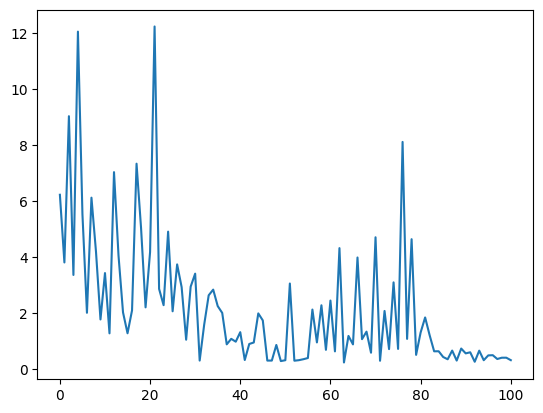

In [10]:
initial_params = rng.uniform(0., 2. * np.pi, size=len(theta))

losses = list()
min_result = optimizer.minimize(objective_function, initial_params)
plt.plot(losses)

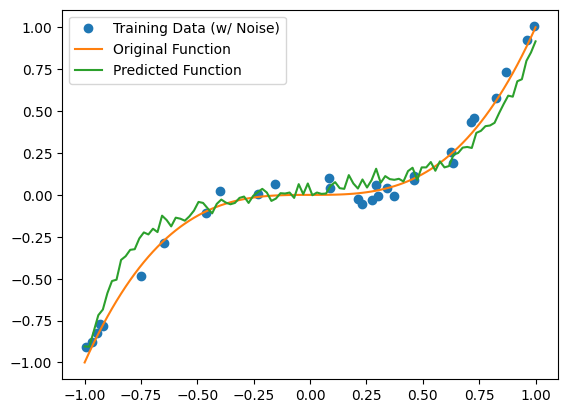

In [11]:
x_list = np.linspace(x_min, x_max, 100)

y_pred = yvals(min_result.x, x_vals=x_list)

# 結果を図示する
plt.plot(x_train, y_train_noise, "o", label='Training Data (w/ Noise)')
plt.plot(x_list, func_to_learn(x_list), label='Original Function')
plt.plot(x_list, np.array(y_pred), label='Predicted Function')
plt.legend();

## 素粒子現象の探索への応用

### 学習データの準備

In [2]:
# ファイルから変数を読み出す
df = pd.read_csv("data/SUSY_1K.csv",
                 names=('isSignal','lep1_pt','lep1_eta','lep1_phi','lep2_pt','lep2_eta',
                        'lep2_phi','miss_ene','miss_phi','MET_rel','axial_MET','M_R','M_TR_2',
                        'R','MT2','S_R','M_Delta_R','dPhi_r_b','cos_theta_r1'))

# 学習に使う変数の数
feature_dim = 3  # dimension of each data point

# 3, 5, 7変数の場合に使う変数のセット
if feature_dim == 3:
    selected_features = ['lep1_pt', 'lep2_pt', 'miss_ene']
elif feature_dim == 5:
    selected_features = ['lep1_pt','lep2_pt','miss_ene','M_TR_2','M_Delta_R']
elif feature_dim == 7:
    selected_features = ['lep1_pt','lep1_eta','lep2_pt','lep2_eta','miss_ene','M_TR_2','M_Delta_R']

# 学習に使う事象数: trainingは訓練用サンプル、testingはテスト用サンプル
train_size = 20
test_size = 20

df_sig = df.loc[df.isSignal==1, selected_features]
df_bkg = df.loc[df.isSignal==0, selected_features]

# サンプルの生成
df_sig_train = df_sig.values[:train_size]
df_bkg_train = df_bkg.values[:train_size]
df_sig_test = df_sig.values[train_size:train_size + test_size]
df_bkg_test = df_bkg.values[train_size:train_size + test_size]
# 最初のtrain_size事象がSUSY粒子を含む信号事象、残りのtrain_size事象がSUSY粒子を含まない背景事象
train_data = np.concatenate([df_sig_train, df_bkg_train])
# 最初のtest_size事象がSUSY粒子を含む信号事象、残りのtest_size事象がSUSY粒子を含まない背景事象
test_data = np.concatenate([df_sig_test, df_bkg_test])

# one-hotベクトル（信号事象では第1次元の第0要素が1、背景事象では第1次元の第1要素が1）
train_label_one_hot = np.zeros((train_size * 2, 2))
train_label_one_hot[:train_size, 0] = 1
train_label_one_hot[train_size:, 1] = 1
test_label_one_hot = np.zeros((test_size * 2, 2))
test_label_one_hot[:test_size, 0] = 1
test_label_one_hot[test_size:, 1] = 1

#datapoints, class_to_label = split_dataset_to_data_and_labels(test_input)
#datapoints_tr, class_to_label_tr = split_dataset_to_data_and_labels(training_input)

mms = MinMaxScaler((-1, 1))
norm_train_data = mms.fit_transform(train_data)
norm_test_data = mms.transform(test_data)

FileNotFoundError: [Errno 2] No such file or directory: 'data/SUSY_1K.csv'

### 量子状態の生成

In [ ]:
#feature_map = ZFeatureMap(feature_dimension=feature_dim, reps=1)
feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=1, entanglement='circular')
feature_map.decompose().draw('mpl')

### 変分フォームを使った状態変換

In [ ]:
ansatz = TwoLocal(num_qubits=feature_dim, rotation_blocks=['ry', 'rz'], entanglement_blocks='cz', entanglement='circular', reps=3)
#ansatz = TwoLocal(num_qubits=feature_dim, rotation_blocks=['ry'], entanglement_blocks='cz', entanglement='circular', reps=3)
ansatz.decompose().draw('mpl')

### 測定とモデル出力

In [15]:
# 上のEstimatorと同じく、バックエンドを使わずシミュレーションを簡略化したSampler
sampler = Sampler()

# 実機で実行する場合
# instance = 'ibm-q/open/main'

# try:
#     service = QiskitRuntimeService(channel='ibm_quantum', instance=instance)
# except AccountNotFoundError:
#     service = QiskitRuntimeService(channel='ibm_quantum', token='__paste_your_token_here__',
#                                    instance=instance)

# backend_name = 'ibm_washington'
# session = Session(service=service, backend=backend_name)

# sampler = RuntimeSampler(session=session)

maxiter = 300

optimizer = COBYLA(maxiter=maxiter, disp=True)

objective_func_vals = []
# Draw the value of objective function every time when the fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    #print('obj_func_eval =',obj_func_eval)

    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(objective_func_vals)
    plt.show()

vqc = VQC(num_qubits=feature_dim,
          feature_map=feature_map,
          ansatz=ansatz,
          loss="cross_entropy",
          optimizer=optimizer,
          callback=callback_graph,
          sampler=sampler)

### シミュレーションで実行

In [ ]:
vqc.fit(norm_train_data, train_label_one_hot)

In [ ]:
train_score = vqc.score(norm_train_data, train_label_one_hot)
test_score = vqc.score(norm_test_data, test_label_one_hot)

print(f'--- Classification Train score: {train_score} ---')
print(f'--- Classification Test score:  {test_score} ---')